### FRAMEWORK: What should signal be when there is no 'nearest' model output?

In [109]:
import pandas as pd
import numpy as np
from datetime import *
from pandas_datareader.data import DataReader
import seaborn as sns

In [110]:
yahoo_url = "https://finance.yahoo.com/quote/%5EDJI/components/"
djia_table = pd.read_html(yahoo_url, header=0, index_col=0)[0]
djia_table = djia_table.reset_index()

In [111]:
def get_data_for_multiple_stocks(tickers):
    '''
    Obtain stocks information (Date, OHLC, Volume and Adjusted Close). 
    Uses Pandas DataReader to make an API Call to Yahoo Finance and download the data directly.
    Computes other values - Log Return and Arithmetic Return.
    
    Input: List of Stock Tickers
    Output: A dictionary of dataframes for each stock
    '''
    stocks = dict()
    for ticker in tickers:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        s.insert(0, "Ticker", ticker)  #insert ticker column so you can reference better later
        s['Date'] = pd.to_datetime(s.index) #useful for transformation later
        s['Prev Close'] = s['Close'].shift(1)
        s['Log Return'] = np.log(s['Close']/s['Prev Close'])
        s['Return'] = (s['Close']/s['Prev Close']-1)
        s = s.reset_index(drop=True)
        
        cols = list(s.columns.values) # re-arrange columns
        cols.remove("Date")
        s = s[["Date"] + cols]
        
        stocks[ticker] = s
        
    return stocks

In [112]:
start_date = "2010-01-01"
end_date = "2019-12-31"
apple_appl = get_data_for_multiple_stocks(["AAPL"])
apple_prices = apple_appl["AAPL"]
apple_prices.head()

,Date,Ticker,High,Low,Open,Close,Volume,Adj Close,Prev Close,Log Return,Return
0,2009-12-31,AAPL,30.478571,30.080000,30.447144,30.104286,88102700.0,26.131752,NaN,NaN,NaN
1,2010-01-04,AAPL,30.642857,30.340000,30.490000,30.572857,123432400.0,26.538483,30.104286,0.015445,0.015565
2,2010-01-05,AAPL,30.798571,30.464285,30.657143,30.625713,150476200.0,26.584366,30.572857,0.001727,0.001729
3,2010-01-06,AAPL,30.747143,30.107143,30.625713,30.138571,138040000.0,26.161509,30.625713,-0.016034,-0.015906
4,2010-01-07,AAPL,30.285715,29.864286,30.250000,30.082857,119282800.0,26.113146,30.138571,-0.001850,-0.001849


In [113]:
apple_prices["Return"].describe()

count    2516.000000
mean        0.001038
std         0.016233
min        -0.123558
25%        -0.006913
50%         0.000895
75%         0.009797
max         0.088741
Name: Return, dtype: float64

Total Long-Only Returns 975.44 %


C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


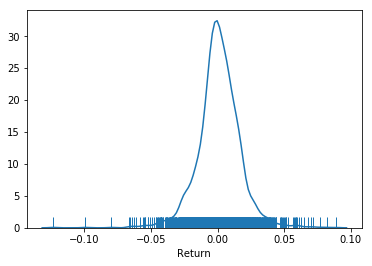

In [114]:
rtns = apple_prices["Return"]
rtns = rtns.dropna()
print("Total Long-Only Returns", round(list(np.cumprod(1+rtns))[-1]*100, 2), "%")
sns.distplot(rtns, rug=True, hist=False)

In [116]:
start_date = "2010-01-01"
end_date = "2019-12-31"

rtns_lst = []

for symbol in djia_table["Symbol"]:
    print(symbol)
    all_data = get_data_for_multiple_stocks([symbol])[symbol]
    rtns = all_data["Return"].dropna()
    tot_rtns = list(np.cumprod(1+rtns))[-1]*100
    
    print(rtns.describe())
    print("Total Long-Only Returns", round(tot_rtns, 2), "%")
    print("------------------------------------")
    
    rtns_lst.append(round(tot_rtns, 0))

AAPL
count    2516.000000
mean        0.001038
std         0.016233
min        -0.123558
25%        -0.006913
50%         0.000895
75%         0.009797
max         0.088741
Name: Return, dtype: float64
Total Long-Only Returns 975.44 %
------------------------------------
PG
count    2516.000000
mean        0.000332
std         0.009412
min        -0.065665
25%        -0.004408
50%         0.000313
75%         0.005326
max         0.087986
Name: Return, dtype: float64
Total Long-Only Returns 206.0 %
------------------------------------
CSCO
count    2516.000000
mean        0.000403
std         0.015853
min        -0.162107
25%        -0.006507
50%         0.000467
75%         0.007909
max         0.159505
Name: Return, dtype: float64
Total Long-Only Returns 200.33 %
------------------------------------
DIS
count    2516.000000
mean        0.000685
std         0.013276
min        -0.091708
25%        -0.005836
50%         0.000760
75%         0.007514
max         0.115437
Name: Return, d

In [117]:
### Make a dataframe based on returns list and symbols
symbols = djia_table["Symbol"]
rtns_lst = pd.Series(rtns_lst)

rtns_df = pd.DataFrame({"Tickers": symbols,
             "Rtns": rtns_lst})

In [118]:
rtns_df["Default Wts"] = (rtns_lst - min(rtns_lst)) / (max(rtns_lst) - min(rtns_lst))
rtns_df

,Tickers,Rtns,Default Wts
0,AAPL,975.0,1.000000
1,PG,206.0,0.119129
2,CSCO,200.0,0.112257
3,DIS,448.0,0.396334
4,UNH,965.0,0.988545
5,INTC,293.0,0.218786
6,MMM,213.0,0.127148
7,CAT,259.0,0.179840
8,CVX,157.0,0.063001
9,V,859.0,0.867125
